In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import control

## Simulate random stable system

In [2]:
def simulate_system(A, B, t_span, ref, Ts, y0=None):
    N = A.shape[0]
    
    if y0 is None:
        y0 = np.zeros(N)
        
    # Form linear system x_dot = Ax + Bu
    def eqn(t,y,ref):
        u = ref(t)
        dydt = A@y + B@u
        return dydt
    
    # Set ODE parameters
    t_eval = np.arange(t_span[0], t_span[1], Ts)
    
    # Simulate system by solving ODE
    sol = solve_ivp(eqn, t_span, y0, t_eval=t_eval, args=(ref,))
    
    return sol.t, sol.y, ref(sol.t)

def ref_sine(t):
    return ( np.sin(t) + np.sin(3*t) ).reshape((-1))

In [20]:
Ts = 0.01
N = 6

# Generate random stable system
A = np.random.rand(N,N)
A = -A @ A.T
B = np.random.rand(N,1)

t, y_true, u_true = simulate_system(A, B, [0,10], ref_sine, Ts)

# Add noise
y = y_true + np.random.randn(*y_true.shape) * (0.05 * np.random.rand(N,1) + 0.05)
u = u_true + 0.1 * np.random.randn(*u_true.shape)

## Initialise and Use Kalman Filter

Wall time: 266 ms


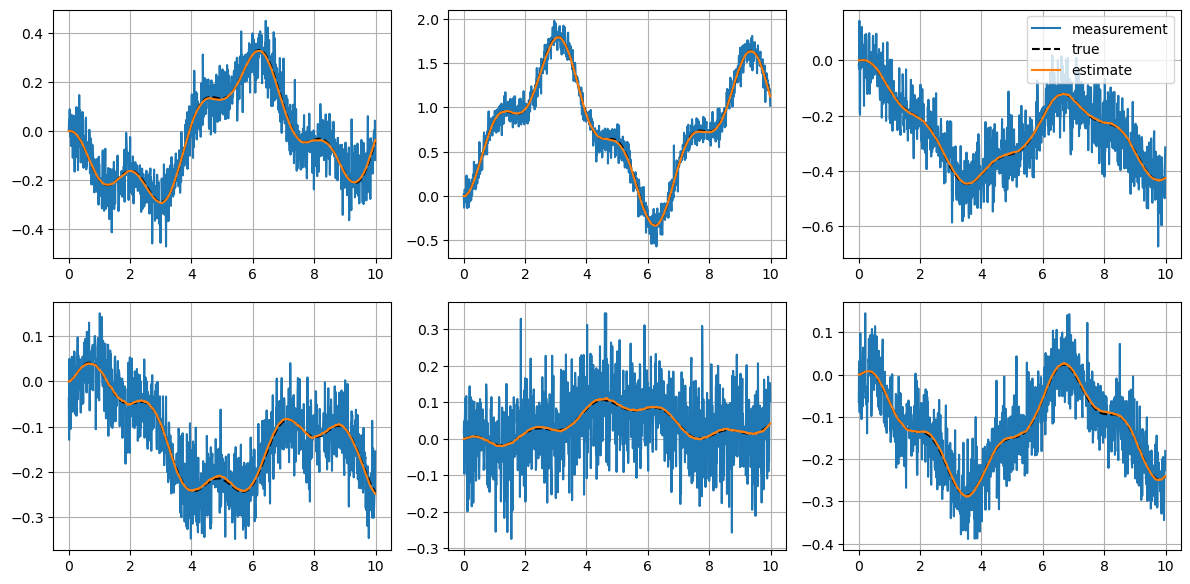

In [22]:
%%time
from estimation.KalmanFilter import KalmanFilter

# # Instantiate Kalman Filter
H = np.eye(N)
# Process Covariance
Q = 1e-2 * np.eye(N)
# Observation Covariance
R = 1e2 * np.eye(N)

kf = KalmanFilter.from_continuous(A,H,Q,R,Ts,B=B)

estimate = np.zeros_like(y)
for i in range(y.shape[1]):
    measurement = y[:,i]
    control_input = u[i:i+1]
    # print(f"meas: {measurement.shape} \t u: {control_input.shape}")
    estimate[:,i] = kf(measurement, control_input)
    # kf(measurement, control_input)

# Unpack
est_pos = estimate[0,:].T
est_vel = estimate[1,:].T

fig,axes = plt.subplots(2, N//2, figsize=(12,6), dpi=100)
fig.tight_layout()
for i,ax in enumerate(axes.flatten()):
    ax.plot(t, y[i,:])
    ax.plot(t, y_true[i,:], 'k--')
    ax.plot(t, estimate[i,:])
    ax.grid()
    
axes[0,2].legend(['measurement', 'true', 'estimate'], loc='upper right')